In [1]:
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import time

#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
# create dataset as df list with uniform dfs
data = {}
labels = []
data_list = []

n_days = 0
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.2)
X_train = np.stack([df.to_numpy() for df in X_train]).astype('float32')
X_test = np.stack([df.to_numpy() for df in X_test]).astype('float32')

train_max = X_train.max(axis=(0, 1))
train_min = X_train.min(axis=(0, 1))

X_train = (X_train - train_min) / (train_max - train_min)
X_test = (X_test - train_min) / (train_max - train_min)
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

603
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
16
587
1156


Epoch 1/25
44/44 [==============================] - 18s 367ms/step - loss: 0.6587 - binary_accuracy: 0.6638 - auc: 0.5121 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5032 - true_negatives: 934.0000 - true_positives: 0.0000e+00 - false_negatives: 473.0000 - false_positives: 0.0000e+00
Epoch 2/25
44/44 [==============================] - 16s 366ms/step - loss: 0.6557 - binary_accuracy: 0.6638 - auc: 0.5026 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5032 - true_negatives: 934.0000 - true_positives: 0.0000e+00 - false_negatives: 473.0000 - false_positives: 0.0000e+00
Epoch 3/25
44/44 [==============================] - 16s 365ms/step - loss: 0.6535 - binary_accuracy: 0.6638 - auc: 0.4955 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.5032 - true_negatives: 934.0000 - true_positives: 0.0000e+00 - false_negatives: 473.0000 - false_positives: 0.0000e+00
Epoch 4/25
44/44 [==============================] - 16s 360ms/step - loss: 0.6518 - binary_accuracy:

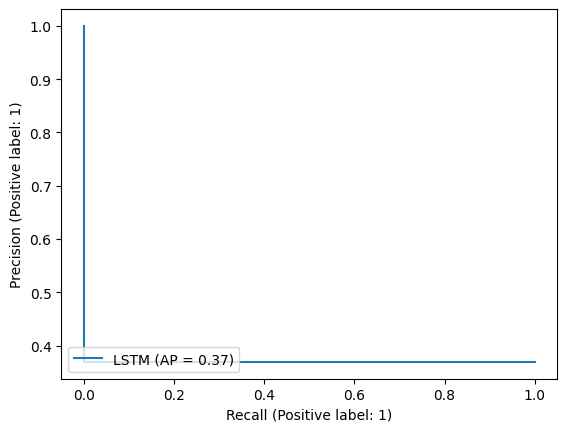

0.3693181818181818


In [2]:
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=20, activation='sigmoid', recurrent_activation='sigmoid', dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
y_test_int = [int(int(i)) for i in y_test]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
44/44 [==============================] - 10s 204ms/step - loss: 0.6923 - binary_accuracy: 0.6610 - auc_2: 0.5000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.5064 - true_negatives_2: 930.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 477.0000 - false_positives_2: 0.0000e+00
Epoch 2/25
44/44 [==============================] - 9s 204ms/step - loss: 0.6913 - binary_accuracy: 0.6610 - auc_2: 0.5087 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.5064 - true_negatives_2: 930.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 477.0000 - false_positives_2: 0.0000e+00
Epoch 3/25
44/44 [==============================] - 10s 217ms/step - loss: 0.6906 - binary_accuracy: 0.6610 - auc_2: 0.5000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.5064 - true_negatives_2: 930.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 477.0000 - false_positives_2: 0.0000e+00
Epoch 4/25
44/44 [==============================] - 9s 207m

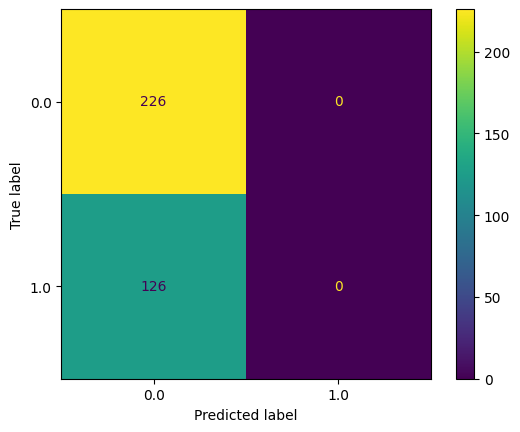

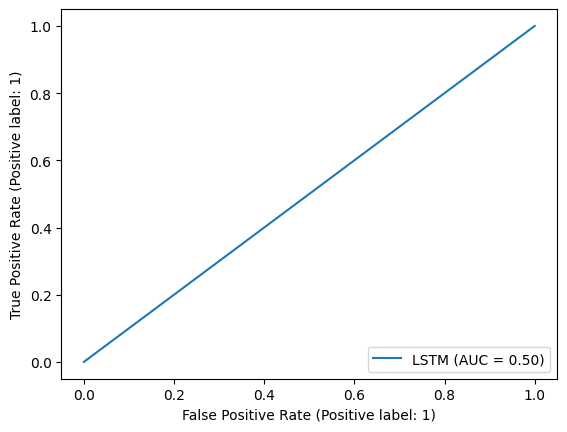

LSTM 1:1 SET 2
[0.6857260465621948, 0.6420454382896423, 0.5, 0.0, 0.0, array([0.52719665], dtype=float32), 226.0, 0.0, 126.0, 0.0]
0.0
0.0
0.0
236.62124579993542
0.7974182999460027


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# SET 2
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=20, activation='tanh', recurrent_activation='tanh', dropout=0))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1 SET 2')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
44/44 [==============================] - 35s 769ms/step - loss: 0.6923 - binary_accuracy: 0.6610 - auc_3: 0.5000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.5064 - true_negatives_3: 930.0000 - true_positives_3: 0.0000e+00 - false_negatives_3: 477.0000 - false_positives_3: 0.0000e+00
Epoch 2/25
44/44 [==============================] - 35s 804ms/step - loss: 0.6913 - binary_accuracy: 0.6610 - auc_3: 0.4951 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.5064 - true_negatives_3: 930.0000 - true_positives_3: 0.0000e+00 - false_negatives_3: 477.0000 - false_positives_3: 0.0000e+00
Epoch 3/25
44/44 [==============================] - 36s 820ms/step - loss: 0.6906 - binary_accuracy: 0.6610 - auc_3: 0.5000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.5064 - true_negatives_3: 930.0000 - true_positives_3: 0.0000e+00 - false_negatives_3: 477.0000 - false_positives_3: 0.0000e+00
Epoch 4/25
44/44 [==============================] - 35s 80

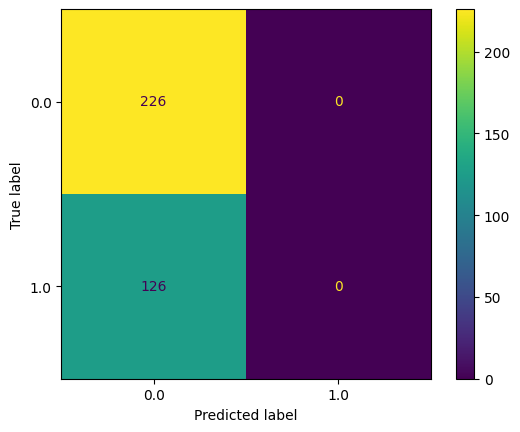

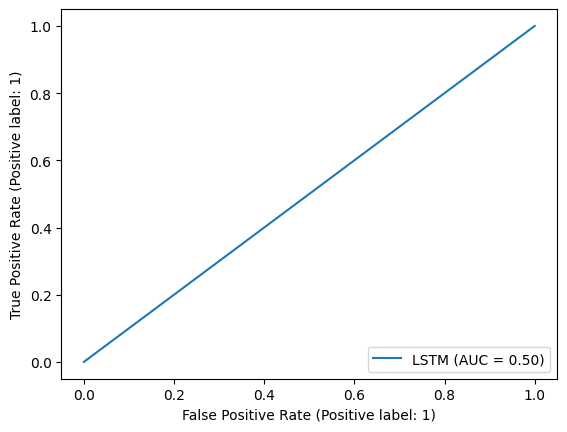

LSTM 1:1 SET 3
[0.6856901049613953, 0.6420454382896423, 0.5, 0.0, 0.0, array([0.52719665], dtype=float32), 226.0, 0.0, 126.0, 0.0]
0.0
0.0
0.0
908.7629575999454
1.3445794000290334


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# SET 3
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=70, activation='tanh', recurrent_activation='tanh', dropout=0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1 SET 3')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

# 1:2 ratio

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers

#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())*2
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
# create dataset as df list with uniform dfs
data = {}
labels = []
data_list = []

n_days = 0
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.2)
X_train = np.stack([df.to_numpy() for df in X_train]).astype('float32')
X_test = np.stack([df.to_numpy() for df in X_test]).astype('float32')

train_max = X_train.max(axis=(0, 1))
train_min = X_train.min(axis=(0, 1))

X_train = (X_train - train_min) / (train_max - train_min)
X_test = (X_test - train_min) / (train_max - train_min)
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

1206
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
96
1110
2273


Epoch 1/25
72/72 [==============================] - 54s 719ms/step - loss: 0.6905 - binary_accuracy: 0.7887 - auc_1: 0.5147 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3489 - true_negatives_1: 1814.0000 - true_positives_1: 0.0000e+00 - false_negatives_1: 486.0000 - false_positives_1: 0.0000e+00
Epoch 2/25
72/72 [==============================] - 47s 652ms/step - loss: 0.6880 - binary_accuracy: 0.7887 - auc_1: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3489 - true_negatives_1: 1814.0000 - true_positives_1: 0.0000e+00 - false_negatives_1: 486.0000 - false_positives_1: 0.0000e+00
Epoch 3/25
72/72 [==============================] - 53s 737ms/step - loss: 0.6863 - binary_accuracy: 0.7887 - auc_1: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3489 - true_negatives_1: 1814.0000 - true_positives_1: 0.0000e+00 - false_negatives_1: 486.0000 - false_positives_1: 0.0000e+00
Epoch 4/25
72/72 [==============================] - 51s

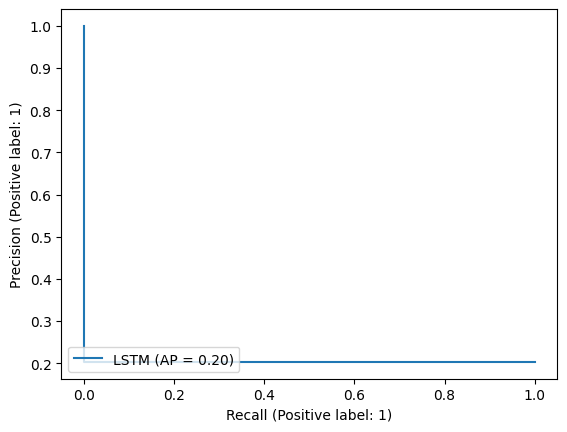

0.203125


In [4]:
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=60, activation='tanh', recurrent_activation='tanh', dropout=0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_double_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:2')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

# full

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers

#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])


# create dataset as df list with uniform dfs
data = {}
labels = []
data_list = []

n_days = 0
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(1)

for user in st['user_id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(0)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.2)
X_train = np.stack([df.to_numpy() for df in X_train]).astype('float32')
X_test = np.stack([df.to_numpy() for df in X_test]).astype('float32')

train_max = X_train.max(axis=(0, 1))
train_min = X_train.min(axis=(0, 1))

X_train = (X_train - train_min) / (train_max - train_min)
X_test = (X_test - train_min) / (train_max - train_min)
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

603


Epoch 1/25
199/199 [==============================] - 92s 453ms/step - loss: 0.6860 - binary_accuracy: 0.9264 - auc_2: 0.4972 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1371 - true_negatives_2: 5893.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 468.0000 - false_positives_2: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 92s 462ms/step - loss: 0.6795 - binary_accuracy: 0.9264 - auc_2: 0.5169 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1371 - true_negatives_2: 5893.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 468.0000 - false_positives_2: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 91s 459ms/step - loss: 0.6754 - binary_accuracy: 0.9264 - auc_2: 0.5000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1371 - true_negatives_2: 5893.0000 - true_positives_2: 0.0000e+00 - false_negatives_2: 468.0000 - false_positives_2: 0.0000e+00
Epoch 4/25
199/199 [=============================

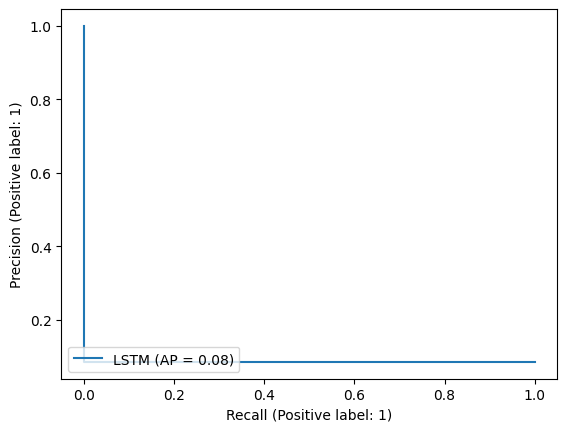

0.08485229415461974


In [6]:
# SET 1
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=30, activation='tanh', recurrent_activation='tanh', dropout=0))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_full_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM Full SET 1')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
199/199 [==============================] - 134s 666ms/step - loss: 0.6861 - binary_accuracy: 0.9231 - auc_6: 0.4899 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1428 - true_negatives_6: 5872.0000 - true_positives_6: 0.0000e+00 - false_negatives_6: 489.0000 - false_positives_6: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 129s 646ms/step - loss: 0.6797 - binary_accuracy: 0.9231 - auc_6: 0.5100 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1428 - true_negatives_6: 5872.0000 - true_positives_6: 0.0000e+00 - false_negatives_6: 489.0000 - false_positives_6: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 131s 658ms/step - loss: 0.6755 - binary_accuracy: 0.9231 - auc_6: 0.5000 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.1428 - true_negatives_6: 5872.0000 - true_positives_6: 0.0000e+00 - false_negatives_6: 489.0000 - false_positives_6: 0.0000e+00
Epoch 4/25
199/199 [==========================

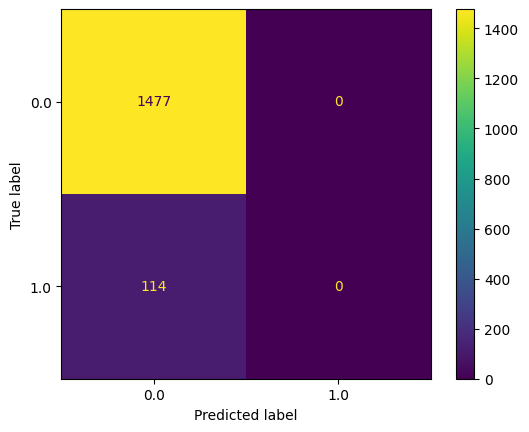

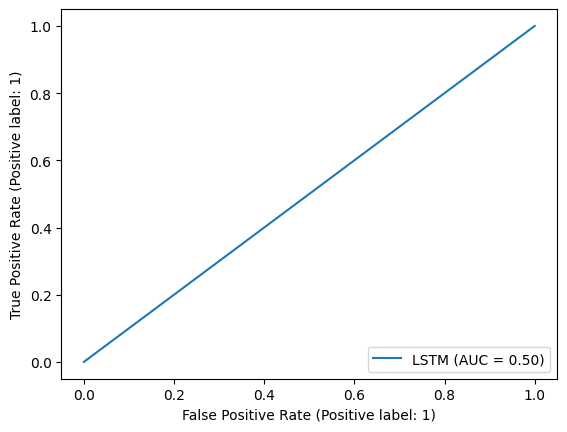

LSTM Full SET 2
[0.6370677947998047, 0.9283469319343567, 0.5, 0.0, 0.0, array([0.13372435], dtype=float32), 1477.0, 0.0, 114.0, 0.0]
0.0
0.0
0.0
3303.0963681000285
5.986071199993603


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# SET 2
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=70, activation='tanh', recurrent_activation='tanh', dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM Full SET 2')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

# baseline & lower tier hps on full data

Epoch 1/25
199/199 [==============================] - 84s 412ms/step - loss: 0.8333 - binary_accuracy: 0.0736 - auc_3: 0.4807 - precision_3: 0.0736 - recall_3: 1.0000 - f1_score: 0.1371 - true_negatives_3: 0.0000e+00 - true_positives_3: 468.0000 - false_negatives_3: 0.0000e+00 - false_positives_3: 5893.0000
Epoch 2/25
199/199 [==============================] - 84s 420ms/step - loss: 0.7486 - binary_accuracy: 0.0736 - auc_3: 0.5221 - precision_3: 0.0736 - recall_3: 1.0000 - f1_score: 0.1371 - true_negatives_3: 0.0000e+00 - true_positives_3: 468.0000 - false_negatives_3: 0.0000e+00 - false_positives_3: 5893.0000
Epoch 3/25
199/199 [==============================] - 86s 429ms/step - loss: 0.6942 - binary_accuracy: 0.4906 - auc_3: 0.4867 - precision_3: 0.0712 - recall_3: 0.4915 - f1_score: 0.1371 - true_negatives_3: 2891.0000 - true_positives_3: 230.0000 - false_negatives_3: 238.0000 - false_positives_3: 3002.0000
Epoch 4/25
199/199 [==============================] - 85s 426ms/step - loss:

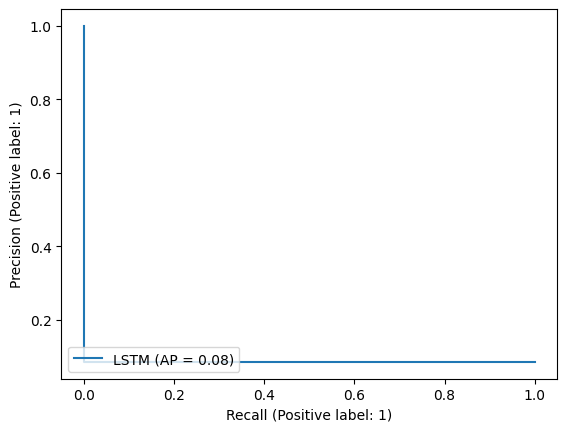

0.08485229415461974


In [7]:
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=20, activation='sigmoid', recurrent_activation='sigmoid', dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_11_on_full_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1 on full')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
199/199 [==============================] - 46s 225ms/step - loss: 0.6861 - binary_accuracy: 0.9231 - auc_8: 0.5150 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.1428 - true_negatives_8: 5872.0000 - true_positives_8: 0.0000e+00 - false_negatives_8: 489.0000 - false_positives_8: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 45s 228ms/step - loss: 0.6797 - binary_accuracy: 0.9231 - auc_8: 0.4812 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.1428 - true_negatives_8: 5872.0000 - true_positives_8: 0.0000e+00 - false_negatives_8: 489.0000 - false_positives_8: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 45s 227ms/step - loss: 0.6756 - binary_accuracy: 0.9231 - auc_8: 0.5000 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.1428 - true_negatives_8: 5872.0000 - true_positives_8: 0.0000e+00 - false_negatives_8: 489.0000 - false_positives_8: 0.0000e+00
Epoch 4/25
199/199 [=============================

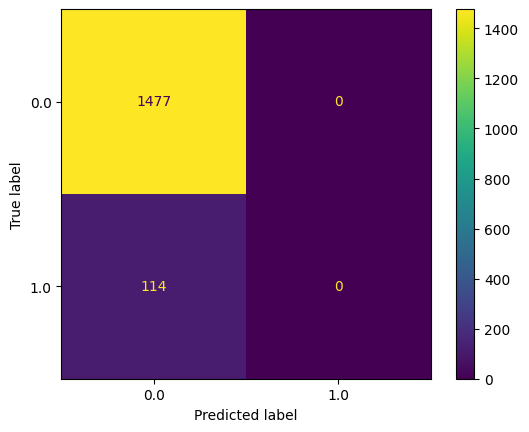

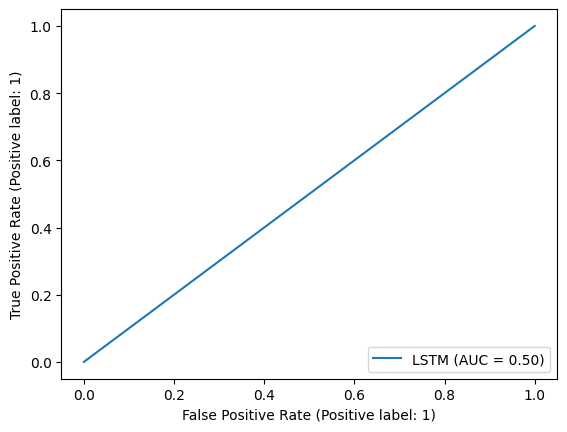

LSTM 1:1 SET 2 on full
[0.6371502876281738, 0.9283469319343567, 0.5, 0.0, 0.0, array([0.13372435], dtype=float32), 1477.0, 0.0, 114.0, 0.0]
0.0
0.0
0.0
1121.919196599978
3.376560700009577


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# SET 2
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=20, activation='tanh', recurrent_activation='tanh', dropout=0))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1 SET 2 on full')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
199/199 [==============================] - 121s 603ms/step - loss: 0.6861 - binary_accuracy: 0.9231 - auc_9: 0.4938 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.1428 - true_negatives_9: 5872.0000 - true_positives_9: 0.0000e+00 - false_negatives_9: 489.0000 - false_positives_9: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 120s 601ms/step - loss: 0.6797 - binary_accuracy: 0.9231 - auc_9: 0.5184 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.1428 - true_negatives_9: 5872.0000 - true_positives_9: 0.0000e+00 - false_negatives_9: 489.0000 - false_positives_9: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 120s 603ms/step - loss: 0.6756 - binary_accuracy: 0.9231 - auc_9: 0.5000 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.1428 - true_negatives_9: 5872.0000 - true_positives_9: 0.0000e+00 - false_negatives_9: 489.0000 - false_positives_9: 0.0000e+00
Epoch 4/25
199/199 [==========================

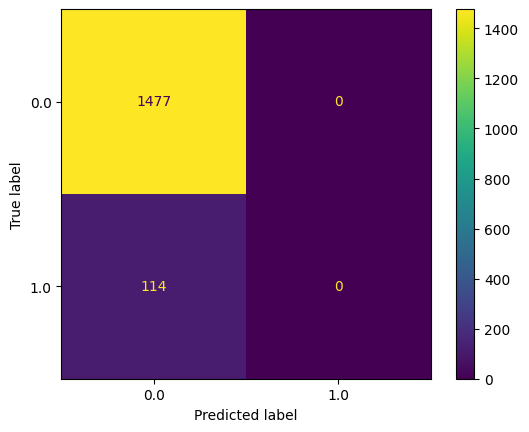

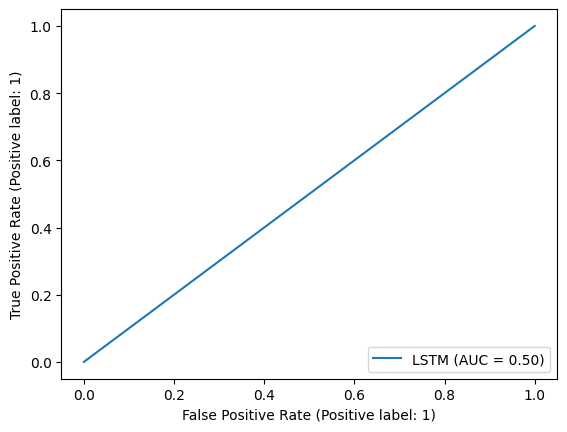

LSTM 1:1 SET 3 on full
[0.6371491551399231, 0.9283469319343567, 0.5, 0.0, 0.0, array([0.13372435], dtype=float32), 1477.0, 0.0, 114.0, 0.0]
0.0
0.0
0.0
3020.065646699979
6.179468199959956


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# SET 3
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=70, activation='tanh', recurrent_activation='tanh', dropout=0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:1 SET 3 on full')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
199/199 [==============================] - 109s 537ms/step - loss: 0.6861 - binary_accuracy: 0.9264 - auc_4: 0.5045 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1371 - true_negatives_4: 5893.0000 - true_positives_4: 0.0000e+00 - false_negatives_4: 468.0000 - false_positives_4: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 111s 557ms/step - loss: 0.6796 - binary_accuracy: 0.9264 - auc_4: 0.5103 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1371 - true_negatives_4: 5893.0000 - true_positives_4: 0.0000e+00 - false_negatives_4: 468.0000 - false_positives_4: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 104s 523ms/step - loss: 0.6754 - binary_accuracy: 0.9264 - auc_4: 0.5000 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1371 - true_negatives_4: 5893.0000 - true_positives_4: 0.0000e+00 - false_negatives_4: 468.0000 - false_positives_4: 0.0000e+00
Epoch 4/25
199/199 [==========================

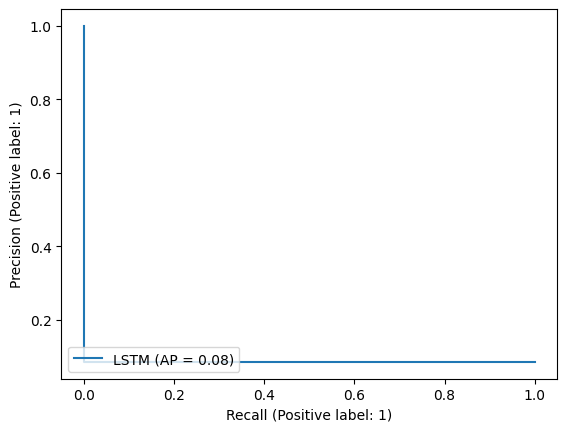

0.08485229415461974


In [8]:
# 1:2 on full
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=60, activation='tanh', recurrent_activation='tanh', dropout=0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='Adagrad', loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_12_on_full_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('LSTM 1:2 on full')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

Epoch 1/25
199/199 [==============================] - 557s 3s/step - loss: 1.1349 - binary_accuracy: 0.9264 - auc_5: 0.5000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1218 - true_negatives_5: 5893.0000 - true_positives_5: 0.0000e+00 - false_negatives_5: 468.0000 - false_positives_5: 0.0000e+00
Epoch 2/25
199/199 [==============================] - 663s 3s/step - loss: 1.1349 - binary_accuracy: 0.9264 - auc_5: 0.5000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1371 - true_negatives_5: 5893.0000 - true_positives_5: 0.0000e+00 - false_negatives_5: 468.0000 - false_positives_5: 0.0000e+00
Epoch 3/25
199/199 [==============================] - 702s 4s/step - loss: 1.1349 - binary_accuracy: 0.9264 - auc_5: 0.5000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1371 - true_negatives_5: 5893.0000 - true_positives_5: 0.0000e+00 - false_negatives_5: 468.0000 - false_positives_5: 0.0000e+00
Epoch 4/25
199/199 [==============================] - 6

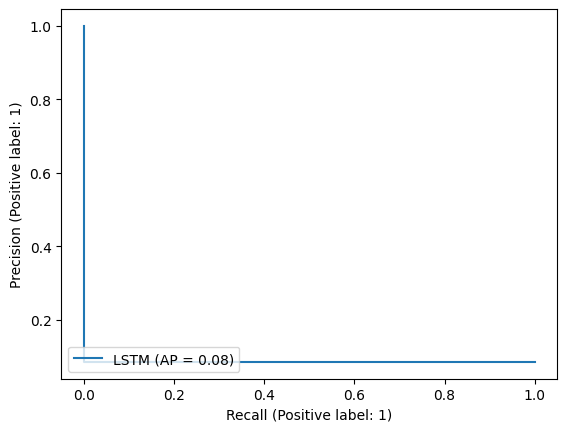

0.08485229415461974


In [9]:
# baseline lstm
from keras import Sequential
from keras import losses, metrics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import precision_recall_fscore_support
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt
import csv


model = Sequential()
model.add(layers.Input(X_train.shape[1:]))
model.add(layers.LSTM(units=100))
model.add(layers.Dense(1))
model.compile(loss=losses.BinaryCrossentropy(), metrics=[metrics.BinaryAccuracy(),metrics.AUC(),metrics.Precision(),metrics.Recall(),metrics.F1Score(), metrics.TrueNegatives(), metrics.TruePositives(), metrics.FalseNegatives(), metrics.FalsePositives()])

start = time.perf_counter()
model.fit(X_train, y_train, epochs=25)
end = time.perf_counter()
train_time = end - start

start = time.perf_counter()
y_pred = model.predict(X_test)
end = time.perf_counter()
test_time = end - start

eval_res = model.evaluate(X_test, y_test)

y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rounded, name='LSTM')
plt.savefig('.\cv_new_figs\lstm_baseline_pr.png')
plt.show()
print(average_precision_score(y_test,y_pred_rounded))

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred_rounded, average='binary', pos_label=1)
print('baseline')
print(eval_res)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

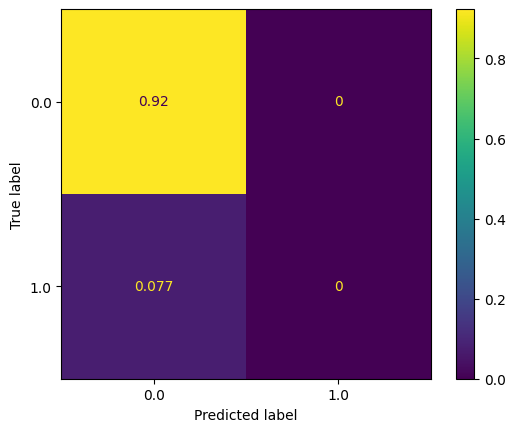

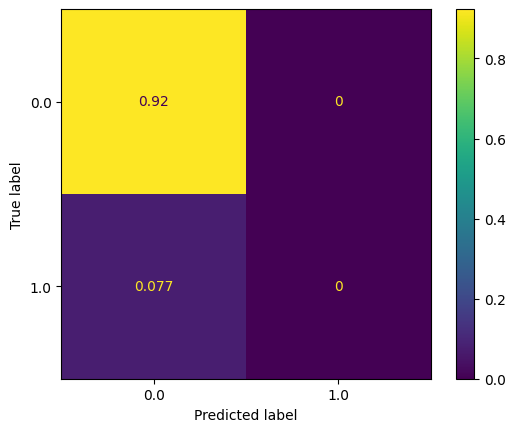

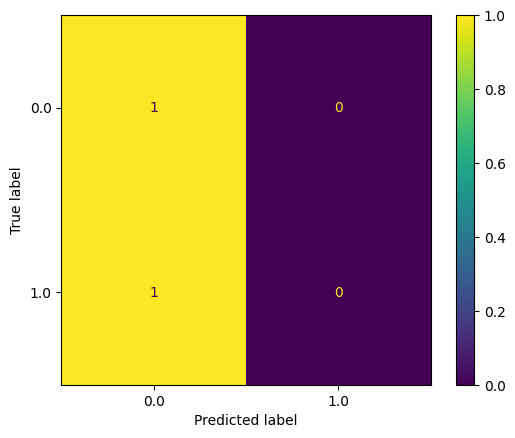

In [18]:
y_pred_rounded = [int(i.round()) for i in y_pred]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rounded, normalize='true')
plt.show()